In [1]:
pip install -U accelerate==0.29.3 peft==0.10.0 bitsandbytes==0.43.1 transformers==4.40.1 trl==0.8.6  datasets==2.19.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112

In [2]:
import os
import torch
from datasets import load_dataset

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer


In [3]:
import huggingface_hub
huggingface_hub.login()

In [4]:
# Hugging Face Basic Model 한국어 모델
base_model = "beomi/Llama-3-Open-Ko-8B"

# Custom Dataset ★ 본인이 hugging face 내 저장한 모델경로를 설정해야함 ★
hkcode_dataset = "hwnam1129/llama3_railcar_trend"

new_model = "Llama-hwnam1129-Ko-3-8B"

In [5]:
dataset = load_dataset(hkcode_dataset, split="train")

# 데이터 확인
print( dataset[28] )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/151 [00:00<?, ? examples/s]

{'text': '<s>[INST] 2024년 12월 04일에 국토교통부, 행정안전부, 고용노동부, 경찰청, 서울시, 인천시  와 관련된 뉴스의 내용은? [/INST] 국토교통부는 4일 행정안전부, 고용노동부, 경찰청, 서울시, 인천시, 경기도, <b>한국철도공사</b> 등 관계기관과 철도파업 대비 수송대책 점검회의를 가졌다고 밝혔다. 박상우 장관이 주재한 이번 회의는 코레일 노사 간 협상이...  </s>'}


In [6]:
if torch.cuda.get_device_capability()[0] >= 8:
    !pip install -qqq flash-attn
    attn_implementation = "flash_attention_2"
    torch_dtype = torch.bfloat16
else:
    attn_implementation = "eager"
    torch_dtype = torch.float16

# QLoRA config
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch_dtype,
    bnb_4bit_use_double_quant=False,
)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [7]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
    # device_map="auto"
)
model.config.use_cache = False
model.config.pretraining_tp = 1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/3.00G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/2.97G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [10]:
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In [11]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_params,
    dataset_text_field="text",
    max_seq_length=None,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:246: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/151 [00:00<?, ? examples/s]

In [12]:
trainer.train()

Step,Training Loss
25,2.021400
50,1.041400
75,0.836300
100,0.678100
125,0.587200
150,0.524800
175,0.462600
200,0.435900
225,0.396600
250,0.313500


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in ver

TrainOutput(global_step=380, training_loss=0.5456899715097328, metrics={'train_runtime': 415.5833, 'train_samples_per_second': 3.633, 'train_steps_per_second': 0.914, 'total_flos': 7805937475878912.0, 'train_loss': 0.5456899715097328, 'epoch': 10.0})

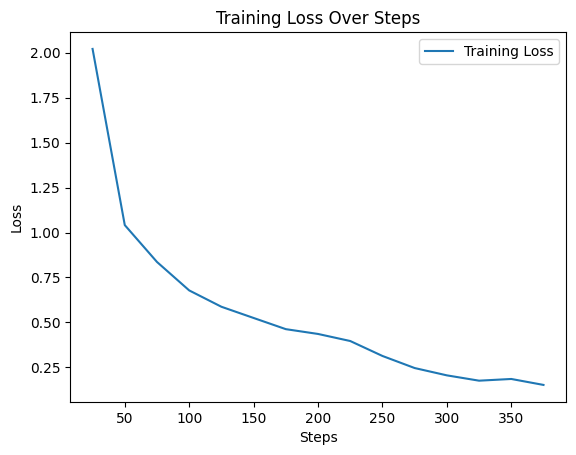

In [13]:
import matplotlib.pyplot as plt

# Trainer 객체에서 loss 값 가져오기
loss_values = []
steps = []

# 훈련 후 log_history에서 loss 값 추출
for log in trainer.state.log_history:
    if 'loss' in log:
        loss_values.append(log['loss'])
        steps.append(log['step'])

# 그래프 그리기
plt.plot(steps, loss_values, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Steps')
plt.legend()
plt.show()

In [15]:
logging.set_verbosity(logging.CRITICAL)

prompt = "12월4일 총파업과 관련된 주요소식은 무엇인가요?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] 12월4일 총파업과 관련된 주요소식은 무엇인가요? [/INST] <b>한국철도공사</b>(코레일)는 열차 안전 운행을 위한 비상수송체제에 돌입했다고 3일 밝혔다. 코레일은 부사장을 중심으로 24시간 비상대책본부를 운영하고, 이용객 불편을 최소화하기 위한...  </td<s>12월4일</s> <b>한국철도공사</b> </td> </tr><tr><s>12월4일</s> <b>한국철도공사</b> </td><td>코레일, 열차 안전 운행 위한 비상수송체제 돌입</td<s>한국철도공사</s> </td></tr><tr><s>12월4일</s


In [17]:
prompt = "12월4일 총파업과 같이 많이 언급된 키워드 3개는 뭐가 있나요?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] 12월4일 총파업과 같이 많이 언급된 키워드 3개는 뭐가 있나요? [/INST] 안전수송, 국민안전, 철도노조  </a> <a href<s>한국철도공사</s>코레일</a> <a href<s>한국철도공사</s>코레일</a> <a href<s>한국철도공사</s>코레일</a> <a href<s>한국철도공사</s>코레일</a> <a href=s>한국철도공사</s>코레일</a> <a href=s>한국철도공사</s>코레일</a> <a href=s>한국철도공사</s>코레일</a> <a href=s>한국철도공사</s>코레일</a


In [18]:
prompt = "12월4일 총파업과 국민안전이 무슨 상관인가요?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST] 12월4일 총파업과 국민안전이 무슨 상관인가요? [/INST] 철도노조 파업으로 열차 안전 운행을 위한 비상수송체제에 돌입하는 철도공사코레일이 전국철도노동조합총파업에 따른 열차 안전 운행을 위한 비상수송체제에 돌입한다고 밝혔습니다. 코레일은 부사장을 중심으로 24시간 비상대책본부를 운영하고...  </<s>12월4일 총파업과 국민안전이 무슨 상관인가요? [/s] 철도노조 파업으로 열차 안전 운행을 위한 비상수송체제에 돌입하는 철도공사코레일이 전국철도노동조합총파업에 따른 열차 안전 운행을 위한 비상수송체제에 돌입


In [19]:
trainer.save_model(new_model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
# # Flush memory
# del trainer, model
# gc.collect()
# torch.cuda.empty_cache()

# # Reload tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained(base_model)
# # model = AutoModelForCausalLM.from_pretrained(
# #     base_model,
# #     low_cpu_mem_usage=True,
# #     return_dict=True,
# #     torch_dtype=torch.float16,
# #     device_map="auto",
# # )

# model = AutoModelForCausalLM.from_pretrained(
#     base_model,
#     quantization_config=quant_config,
#     device_map={"": 0},
#     torch_dtype=torch.float16
#     # device_map="auto"
# )

# model, tokenizer = setup_chat_format(model, tokenizer)

# # Merge adapter with base model
# model = PeftModel.from_pretrained(model, new_model)
# model = model.merge_and_unload()
# model.push_to_hub(new_model, use_temp_dir=False)
# tokenizer.push_to_hub(new_model, use_temp_dir=False)

In [22]:
model.push_to_hub('hwnam1129/Llama-hwnam1129-Ko-3-8B')

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.24G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/hwnam1129/Llama-hwnam1129-Ko-3-8B/commit/167b59e810b5fb0ea415ada8451b6b8e89cd27ce', commit_message='Upload LlamaForCausalLM', commit_description='', oid='167b59e810b5fb0ea415ada8451b6b8e89cd27ce', pr_url=None, repo_url=RepoUrl('https://huggingface.co/hwnam1129/Llama-hwnam1129-Ko-3-8B', endpoint='https://huggingface.co', repo_type='model', repo_id='hwnam1129/Llama-hwnam1129-Ko-3-8B'), pr_revision=None, pr_num=None)